In [1]:
import gymnasium as gym
import miniworld
from matplotlib import pyplot as plt

miniworld_env_ids = [env_id for env_id in gym.registry if "MiniWorld" in env_id]

2025-06-08 12:03:06.594 Python[47071:2815175] ApplePersistenceIgnoreState: Existing state will not be touched. New state will be written to /var/folders/zz/_8nvyjvj4jd9v1rfts46s0ph0000gn/T/com.apple.python3.savedState


In [2]:
print(miniworld_env_ids)

['MiniWorld-CollectHealth-v0', 'MiniWorld-FourRooms-v0', 'MiniWorld-Hallway-v0', 'MiniWorld-Maze-v0', 'MiniWorld-MazeS2-v0', 'MiniWorld-MazeS3-v0', 'MiniWorld-MazeS3Fast-v0', 'MiniWorld-OneRoom-v0', 'MiniWorld-OneRoomS6-v0', 'MiniWorld-OneRoomS6Fast-v0', 'MiniWorld-PickupObjects-v0', 'MiniWorld-PutNext-v0', 'MiniWorld-RoomObjects-v0', 'MiniWorld-Sidewalk-v0', 'MiniWorld-Sign-v0', 'MiniWorld-TMaze-v0', 'MiniWorld-TMazeLeft-v0', 'MiniWorld-TMazeRight-v0', 'MiniWorld-ThreeRooms-v0', 'MiniWorld-WallGap-v0', 'MiniWorld-YMaze-v0', 'MiniWorld-YMazeLeft-v0', 'MiniWorld-YMazeRight-v0']


In [3]:
def make_env():
    env = gym.make("MiniWorld-Maze-v0")
    return env

In [6]:
"""
The observation space is an `ndarray` with shape `(obs_height, obs_width, 3)`
representing an RGB image of what the agents see.
"""

"""
class Actions(IntEnum):
      # Turn left or right by a small amount
      turn_left = 0
      turn_right = 1

      # Move forward or back by a small amount
      move_forward = 2
      move_back = 3

      # Pick up or drop an object being carried
      pickup = 4
      drop = 5

      # Toggle/activate an object
      toggle = 6

      # Done completing task
      done = 7
"""

env = make_env()

Falling back to num_samples=4
Falling back to non-multisampled frame buffer
Falling back to num_samples=4
Falling back to non-multisampled frame buffer


Discrete(3)
Box(0, 255, (60, 80, 3), uint8)
{'render.modes': ['human', 'rgb_array'], 'video.frames_per_second': 30, 'render_modes': ['human', 'rgb_array'], 'render_fps': 30}
this is obv
[[[80 61 52]
  [81 57 48]
  [83 59 50]
  ...
  [80 64 55]
  [81 66 58]
  [82 65 57]]

 [[80 59 50]
  [82 54 44]
  [84 55 45]
  ...
  [76 53 45]
  [77 53 45]
  [78 54 45]]

 [[76 62 54]
  [77 60 52]
  [79 63 55]
  ...
  [80 60 52]
  [80 61 53]
  [81 61 52]]

 ...

 [[76 65 58]
  [75 62 54]
  [75 62 55]
  ...
  [79 61 52]
  [80 62 54]
  [82 64 55]]

 [[70 55 48]
  [68 54 47]
  [70 56 48]
  ...
  [78 57 48]
  [77 58 50]
  [82 61 51]]

 [[76 62 54]
  [74 59 51]
  [75 60 52]
  ...
  [80 66 59]
  [79 66 59]
  [81 67 59]]]
{}
0.0
25.75
0.0
25.75


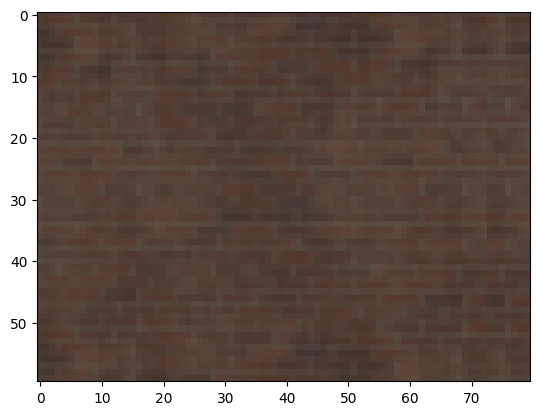

In [29]:
print(env.action_space)
print(env.observation_space)
print(env.metadata)
obs, info = env.reset()
print("this is obv")
print(obs)
print(info)

print(env.get_wrapper_attr('min_x'))
print(env.get_wrapper_attr('max_x'))
print(env.get_wrapper_attr('min_z'))
print(env.get_wrapper_attr('max_z'))
plt.imshow(obs)

[15.11847623  0.          7.04075402]
-2.277883153938806


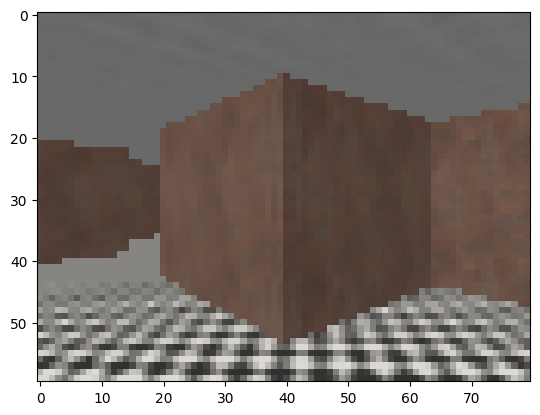

In [8]:
# Turn left or right by a small amount
turn_left = 0
turn_right = 1

# Move forward or back by a small amount
move_forward = 2
move_back = 3

# Pick up or drop an object being carried
pickup = 4
drop = 5

# Toggle/activate an object
toggle = 6

# Done completing task
done = 7

obs, reward, terminated, truncated, info = env.step(1)
print(env.get_wrapper_attr('agent').pos)
print(env.get_wrapper_attr('agent').dir)
plt.imshow(obs)


In [1]:
import gymnasium as gym
from vectorhash import build_vectorhash_architecture
from shifts import RatShift
from smoothing import RatSLAMSmoothing
import miniworld
from miniworld.params import DEFAULT_PARAMS
from miniworld_agent import MiniworldVectorhashAgent
import math
import torch

### vhash
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
    
shapes = [(3, 3, 4), (4, 4, 5)]


def make_env():
    params = DEFAULT_PARAMS.copy().no_random()
    env = gym.make("MiniWorld-Maze-v0", max_episode_steps=-1, params=params, domain_rand=False)
    min_x = env.get_wrapper_attr("min_x")
    max_x = env.get_wrapper_attr("max_x")
    min_z = env.get_wrapper_attr("min_z")
    max_z = env.get_wrapper_attr("max_z")

    limits = torch.tensor([max_x - min_x, max_z - min_z, 2 * math.pi]).float()
    return env, limits


env, limits = make_env()
model = build_vectorhash_architecture(
    shapes,
    N_h=600,
    input_size=128,
    initalization_method="by_sparsity",
    limits=limits,
    device=device,
    shift=RatShift(),
    smoothing=RatSLAMSmoothing(device=device),
)


#### agent
agent = MiniworldVectorhashAgent(model, env)

2025-06-08 12:18:51.870 Python[47242:2824272] ApplePersistenceIgnoreState: Existing state will not be touched. New state will be written to /var/folders/zz/_8nvyjvj4jd9v1rfts46s0ph0000gn/T/com.apple.python3.savedState


Falling back to num_samples=4
Falling back to non-multisampled frame buffer
Falling back to num_samples=4
Falling back to non-multisampled frame buffer
by_sparsity
module shapes:  [(3, 3, 4), (4, 4, 5)]
N_g     :  116
N_patts :  2880
N_h     :  600


RuntimeError: Given groups=1, weight of size [16, 3, 3, 3], expected input[1, 1, 84, 84] to have 3 channels, but got 1 channels instead

In [25]:
print(limits)

tensor([25.7500, 25.7500,  6.2832])


In [26]:
path = [0] * 18 + [3] * 10

In [27]:
import torch
from agent import path_test

results = path_test(agent, path, limits=torch.tensor([1, 1, 2 * math.pi / 8]))

info for each h directly after learning it
h max, min, mean tensor(6.3576, device='mps:0') tensor(0., device='mps:0') tensor(1.8309, device='mps:0')
h_from_s max, min, mean tensor(6.3575, device='mps:0') tensor(0., device='mps:0') tensor(1.8309, device='mps:0')
h_from_s_denoised max, min, mean tensor(2.3218, device='mps:0') tensor(1.2339, device='mps:0') tensor(1.7251, device='mps:0')
avg nonzero/greaterzero h from book: tensor(540, device='mps:0') tensor(540, device='mps:0')
avg nonzero/greaterzero h from s: tensor(540, device='mps:0') tensor(540, device='mps:0')
avg nonzero/greaterzero h from s denoised: tensor(600, device='mps:0') tensor(600, device='mps:0')
mse/cosinesimilarity h from book and h from s tensor(1.2908e-10, device='mps:0') tensor([1.], device='mps:0')
mse/cosinesimilarity h from book and h from s denoised tensor(1.4551, device='mps:0') tensor([0.8383], device='mps:0')
mse/cosinesimilarity s and s from h from s tensor(7.9454e-11, device='mps:0') tensor([1.], device='mp

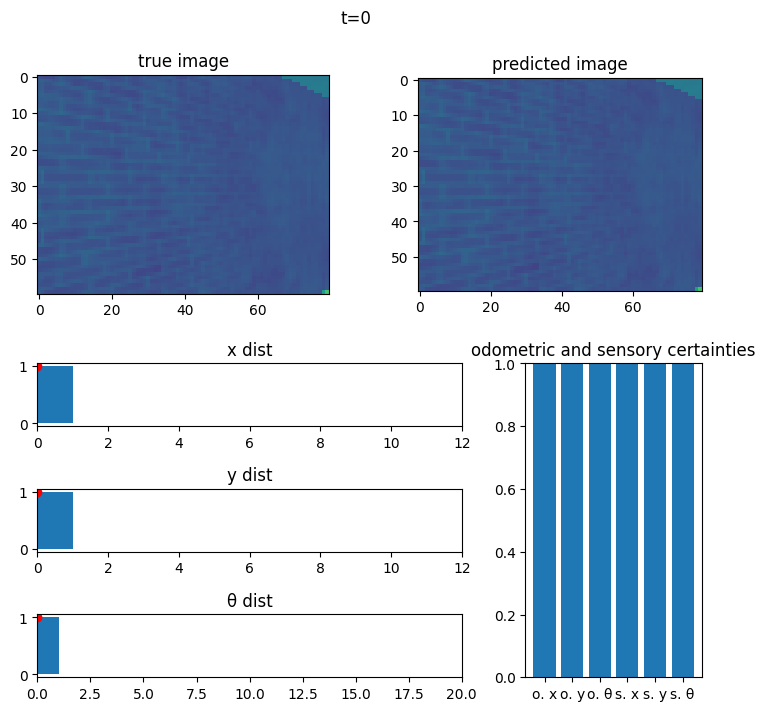

In [28]:
history = results[1]
ani = history.make_image_video()

In [ ]:
ani.save("gifs/testpath4.gif", progress_callback=lambda current, total: print(f"frame {current}/{total}"), dpi=150)